# Reference Paper

## *<span style="color:#007acc;">GSR Analysis for Stress: Development and Validation of an Open Source Tool for Noisy Naturalistic GSR Data</span>*

The paper introduces a Python package named <span style="color:#007acc;">`pyEDA`</span> designed for processing and analyzing Electrodermal Activity (EDA) data. It provides a comprehensive framework for handling noisy naturalistic data and offers various analytical tools for stress analysis. The authors present the development process of the package along with its validation, demonstrating its efficacy in real-world scenarios.


In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import scipy.stats as stats  # To perform the ANOVA testing
from scipy.stats import f_oneway
import pingouin as pg # Necessary, to conduct the Welch's ANOVA testing  
import scipy.signal as sps # This package is necessary for the preprocessing steps
from scipy.signal import butter, filtfilt # For filtering the data and applying the low-pass Butterworth filter on the phasic data

In [2]:
# The first step is reading in the dataset containing the GRS data.
# As we have more than 20 data sets, it will be more convenient to read them individually, meaning one participant at a time  
pt_1 = pd.read_csv("./Data_Sets/CogLoad2-snake/raw/0dah3_sensors.csv")
pt_1.head()

,datetime,timestamp,user_id,level,task,hr,gsr,rr,temperature,TLX_mental_demand,TLX_physical_demand,TLX_temporal_demand,TLX_performance,TLX_effort,TLX_frustration,points,subjective_diff,subjective_fun,click_per_second
0,2019-06-27 08:45:35.721,1561625135721,0dah3,2,snake,80,4.975124,0.929152,33.98,15,0,18,8,15,0,0,16,14,0.0
1,2019-06-27 08:45:36.722,1561625136722,0dah3,2,snake,80,4.926108,0.783972,33.98,15,0,18,8,15,0,0,16,14,0.4
2,2019-06-27 08:45:37.725,1561625137725,0dah3,2,snake,80,4.854369,0.754936,33.98,15,0,18,8,15,0,0,16,14,0.4
3,2019-06-27 08:45:38.739,1561625138739,0dah3,2,snake,80,4.807692,0.663680,33.98,15,0,18,8,15,0,0,16,14,0.4
4,2019-06-27 08:45:39.739,1561625139739,0dah3,2,snake,80,4.784689,0.680272,33.98,15,0,18,8,15,0,0,16,14,0.4


In [3]:
# Reading an additional dataset
pt_2 = pd.read_csv("./Data_Sets/CogLoad2-snake/raw/3190o_sensors.csv")
pt_2.head()

,datetime,timestamp,user_id,level,task,hr,gsr,rr,temperature,TLX_mental_demand,TLX_physical_demand,TLX_temporal_demand,TLX_performance,TLX_effort,TLX_frustration,points,subjective_diff,subjective_fun,click_per_second
0,2019-06-04 08:13:15.503,1559635995503,3190o,0,snake,83,0.120351,0.669211,29.26,2,0,5,19,7,0,0,2,10,0.4
1,2019-06-04 08:13:16.502,1559635996502,3190o,0,snake,83,0.120671,0.667828,29.26,2,0,5,19,7,0,0,2,10,0.4
2,2019-06-04 08:13:17.503,1559635997503,3190o,0,snake,83,0.120671,0.676954,29.26,2,0,5,19,7,0,0,2,10,0.8
3,2019-06-04 08:13:18.505,1559635998505,3190o,0,snake,83,0.120351,0.692716,29.26,2,0,5,19,7,0,0,2,10,0.8
4,2019-06-04 08:13:19.504,1559635999504,3190o,0,snake,87,0.121581,0.696864,29.26,2,0,5,19,7,0,0,2,10,0.8


In [4]:
# From the data that we have read "pt_1", we want to define the specific column that contains the GSR data.
# Note: The GSR stands for "Galvanic Skin Response" and can also be called EDA "Electrodermal Activity", SC "Skin Conductance, EDR "Electrodermal Response and PGR "Psychogalvanic Reflex"
eda  = pt_1["gsr"]

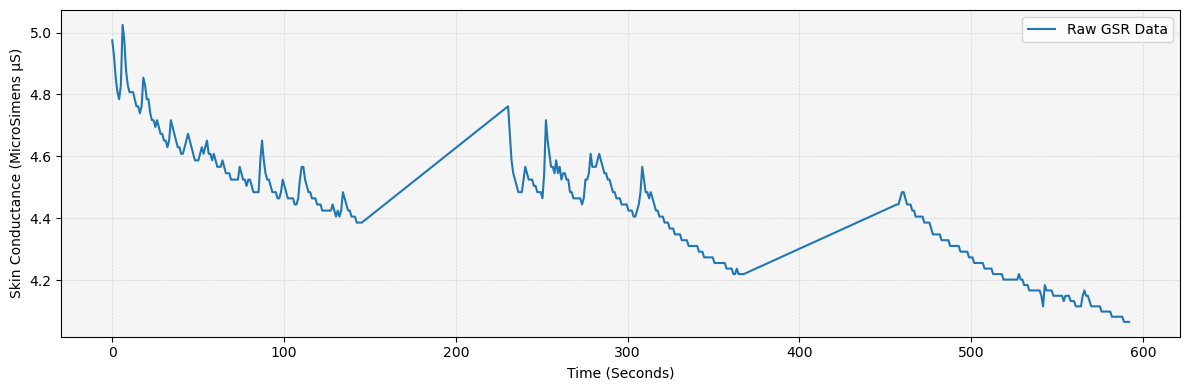

In [5]:
# Visualising The Data

# In order to visualize the GSR data, the column "datetime" should be converted from strings to datetime objects for plotting
datetime_series = pd.to_datetime(pt_1['datetime'])

# Convert datetime_series to seconds from the first datetime point
# Subtract the first element of the series from all elements, convert to 'timedelta64[s]' to get seconds
seconds_from_start = (datetime_series - datetime_series.iloc[0]).dt.total_seconds()

# Defining the directory
plots_dir = "./Plots"

# Plot the data with datetime on the X-axis
plt.figure(figsize=(12, 4))
plt.plot(seconds_from_start, eda, label = "Raw GSR Data")  # Use datetime_series for the X-axis
# Add grid to the plot with light grey color and dashed line style
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
# Further customization to modify the background colour of the plot area
plt.gca().set_facecolor('whitesmoke')  # This sets the plot background to a light grey colour, similar to 'whitesmoke'
plt.legend()
plt.xlabel('Time (Seconds)')
plt.ylabel('Skin Conductance (MicroSimens μS)')

plt.xticks(rotation=0)  # Rotate the x-axis labels to make them more readable
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels


# Save the plot to the "Plots" directory folder that is within the same directory of this .ipynb file
plt.savefig(os.path.join(plots_dir, 'Raw_GSR_Data_Over_Time.png'))

plt.show()

In [6]:
# Preprocessing (Participant 1)
# This is the first step when dealing with GSR data. The step encompasses three main sub-steps being downsampling, moving average and normalization
# Downsampling: Reducing the data's sampling rate conserves memory and processing time without significant signal loss. 
#               Research suggests downsampling to 20 Hz or lower from the original 128 Hz.  
# Moving Average & Normalization:  After down-sampling, a 1-second moving average smooths the data, reducing artefacts from body movements. (REFRENCES)
#                                  Subsequently, min-max normalization reduces interindividual variance, enhancing data consistency for analysis.

# Again, defining the GSR data has been performed before but added here for clarity  
eda = pt_1["gsr"]  # pt_1 represents the data for the first participant 

# Defining the resampling parameters
# Actually, resampling is not needed for this data since the GSR data was sampled at 1 Hz. However, this is added to maintain clarity!
prevSR = 1  # Previous sample rate in Hz
newSR = 1   # New sample rate in Hz

# Normalization and Rolling Mean parameters
windowsize = 5  # Window size in seconds. The original data is collected approximately every 1 second, thus the rolling was done for 5 seconds  
sample_rate = newSR  # Using the new sample rate
# ------------------------------------------------------------ #
# Resampling the data
number_of_samples = int(round(len(eda) * float(newSR) / prevSR))  # Calculates the number of samples needed for resampling the Electrodermal Activity (EDA) data
resampled_eda = sps.resample(eda, number_of_samples) # Performs the actual resampling of the EDA data using SciPy's resample() function
# ------------------------------------------------------------ #
# Normalizing the data
normalized_eda = resampled_eda - np.min(resampled_eda)
# The previous line subtracts the minimum value of the resampled EDA data (np.min(resampled_eda)) from every data point. 
# This operation shifts the data such that the minimum value becomes zero, ensuring all values are positive or zero.
normalized_eda /= (np.max(resampled_eda) - np.min(resampled_eda))
# This line divides each data point by the range of the resampled EDA data (np.max(resampled_eda) - np.min(resampled_eda)). 
# This operation scales the data such that the maximum value becomes 1 and the minimum value becomes 0, effectively normalizing the data to the range [0, 1].
# ------------------------------------------------------------ #
# Calculating the rolling mean
avg_hr = np.mean(normalized_eda)
t_windowsize = int(windowsize * sample_rate)
t_shape = normalized_eda.shape[:-1] + (normalized_eda.shape[-1] - t_windowsize + 1, t_windowsize)
t_strides = normalized_eda.strides + (normalized_eda.strides[-1],)
sep_win = np.lib.stride_tricks.as_strided(normalized_eda, shape=t_shape, strides=t_strides)
rol_mean_eda = np.mean(sep_win, axis=1)
# ------------------------------------------------------------ #
# Padding the start and end of the rolling mean array to match the original data length
missing_vals = np.array([avg_hr for _ in range(0, int(abs(len(normalized_eda) - len(rol_mean_eda))/2))])
rol_mean_eda = np.insert(rol_mean_eda, 0, missing_vals)
rol_mean_eda = np.append(rol_mean_eda, missing_vals)

# Adjusting the length of the rolling mean array to exactly match the input data's length
if len(rol_mean_eda) != len(normalized_eda):  # Generally not expected to execute
    lendiff = len(rol_mean_eda) - len(normalized_eda)
    if lendiff < 0:
        rol_mean_eda = np.append(rol_mean_eda, 0)
    else:
        rol_mean_eda = rol_mean_eda[:-1]

# At this point, 'rol_mean_eda' is the final preprocessed data ready for further analysis!


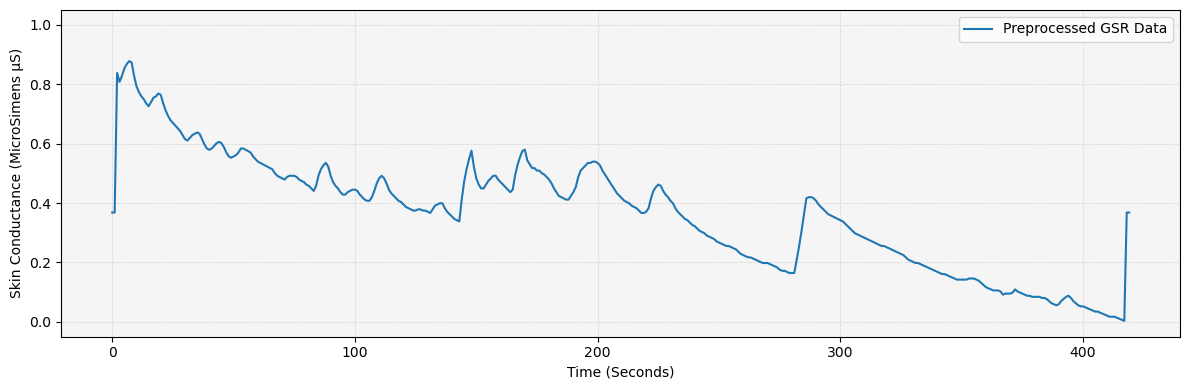

In [7]:
# Plotting The Preprocessed GSR Data

# Creating a time series corresponding to the preprocessed data
# As the sampling rate is 1 Hz, a time series can be created by just creating a range with the same number of elements as the preprocessed data
time_series = np.arange(len(rol_mean_eda))


plt.figure(figsize=(12, 4))
plt.plot(time_series, rol_mean_eda, label='Preprocessed GSR Data')
plt.xlabel('Time (Seconds)')
plt.ylabel('Skin Conductance (MicroSimens μS)') # Now, on the y-axis we can see the "Normalized Skin Conductance (0-1)"

# Add a grid to the plot with light grey color and dashed line style
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
# Set the face color of the plot area
plt.gca().set_facecolor('whitesmoke')
plt.legend()

# Set y-axis limits from 0 to 1
plt.ylim(-0.05, 1.05)

# Set y-axis ticks explicitly from 0 to 1 with a step of 0.2
plt.yticks(np.arange(0, 1.01, 0.2))

plt.tight_layout()  # Adjust layout to make room for the x-axis labels if rotated
# Save the plot to the "Plots" directory
plt.savefig(os.path.join(plots_dir, 'Preprocessed_GSR_Data_Over_Time.png'))
plt.show()

In [8]:
# Feature Extraction
# Three statistical features: the number of peaks, the mean of GSR, and the maximum peak amplitude. 
# Step (1): Identifying peaks in the GSR data
peaks, _ = sps.find_peaks(rol_mean_eda)

# Extracting the peak values from the data
peak_values = rol_mean_eda[peaks]

# Calculating the maximum of the peaks directly
max_peak_value = np.max(peak_values) if len(peak_values) > 0 else 0

# Calculating the mean of the GSR data
mean_gsr = np.mean(rol_mean_eda)

# Calculating the number of peaks directly
number_of_peaks = len(peaks)
# ------------------------------------------------------------ #
print(f"Maximum peak value: {max_peak_value}")
print(f"Mean of the GSR data: {mean_gsr}")
print(f"Number of peaks: {number_of_peaks}")
# ------------------------------------------------------------ #
# The calculations associated with (1) calculating the peak values of the data and (2) calculating the maximum number of peaks are not precisely correct!
# Here is a summary of the actual steps that need to be followed:

# (1) Extract Phasic Data:
#     Extract the phasic component from the preprocessed GSR signal.

# (2) Apply Low-pass Butterworth Filter:
#     Use a low-pass Butterworth filter on the phasic data to eliminate line noise.
#     Set the cutoff frequency to 5 Hz divided by the sampling rate of the data.

# (3) Identify Onset and Offsets:
#     Determine the onset and offset points in the filtered data.

# (4) Find Peaks:
#     a. Within each onset-offset window:
#        Locate the maximum amplitude value.
#     b. Calculate Peak Amplitude:
#        Subtract the amplitude value at onset from the maximum amplitude.
#     c. Threshold Check:
#        If the resulting peak amplitude is higher than the threshold, typically 0.005, count it as a peak.

Maximum peak value: 0.8780329619248797
Mean of the GSR data: 0.3673670891901861
Number of peaks: 30


In [9]:
# Phasic Component Extraction

"""
______________________________________________________________________________

 File:                         cvxEDA.py
 Last revised:                 07 Nov 2015 r69
 ______________________________________________________________________________

 Copyright (C) 2014-2015 Luca Citi, Alberto Greco
 
 This program is free software; you can redistribute it and/or modify it under
 the terms of the GNU General Public License as published by the Free Software
 Foundation; either version 3 of the License, or (at your option) any later
 version.
 
 This program is distributed in the hope that it will be useful, but WITHOUT
 ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
 FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
 
 You may contact the author by e-mail (lciti@ieee.org).
 ______________________________________________________________________________

 This method was first proposed in:
 A Greco, G Valenza, A Lanata, EP Scilingo, and L Citi
 "cvxEDA: a Convex Optimization Approach to Electrodermal Activity Processing"
 IEEE Transactions on Biomedical Engineering, 2015
 DOI: 10.1109/TBME.2015.2474131

 If you use this program in support of published research, please include a
 citation of the reference above. If you use this code in a software package,
 please explicitly inform the end users of this copyright notice and ask them
 to cite the reference above in their published research.
 ______________________________________________________________________________
"""

# Importing necessary libraries
import numpy as np
import cvxopt as cv
import cvxopt.solvers

def cvxEDA(y, delta, tau0=2., tau1=0.7, delta_knot=10., alpha=8e-4, gamma=1e-2,
           solver=None, options={'reltol':1e-9}):
    """CVXEDA Convex optimization approach to electrodermal activity processing

    This function implements the cvxEDA algorithm described in "cvxEDA: a
    Convex Optimization Approach to Electrodermal Activity Processing"
    (http://dx.doi.org/10.1109/TBME.2015.2474131, also available from the
    authors' homepages).

    Arguments:
       y: observed EDA signal (we recommend normalizing it: y = zscore(y))
       delta: sampling interval (in seconds) of y
       tau0: slow time constant of the Bateman function
       tau1: fast time constant of the Bateman function
       delta_knot: time between knots of the tonic spline function
       alpha: penalization for the sparse SMNA driver
       gamma: penalization for the tonic spline coefficients
       solver: sparse QP solver to be used, see cvxopt.solvers.qp
       options: solver options, see:
                http://cvxopt.org/userguide/coneprog.html#algorithm-parameters

    Returns (see paper for details):
       r: phasic component
       p: sparse SMNA driver of phasic component
       t: tonic component
       l: coefficients of tonic spline
       d: offset and slope of the linear drift term
       e: model residuals
       obj: value of objective function being minimized (eq 15 of paper)
    """

    n = len(y)
    y = cv.matrix(y)

    # bateman ARMA model
    a1 = 1./min(tau1, tau0) # a1 > a0
    a0 = 1./max(tau1, tau0)
    ar = np.array([(a1*delta + 2.) * (a0*delta + 2.), 2.*a1*a0*delta**2 - 8.,
        (a1*delta - 2.) * (a0*delta - 2.)]) / ((a1 - a0) * delta**2)
    ma = np.array([1., 2., 1.])

    # matrices for ARMA model
    i = np.arange(2, n)
    A = cv.spmatrix(np.tile(ar, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))
    M = cv.spmatrix(np.tile(ma, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))

    # spline
    delta_knot_s = int(round(delta_knot / delta))
    spl = np.r_[np.arange(1.,delta_knot_s), np.arange(delta_knot_s, 0., -1.)] # order 1
    spl = np.convolve(spl, spl, 'full')
    spl /= max(spl)
    # matrix of spline regressors
    i = np.c_[np.arange(-(len(spl)//2), (len(spl)+1)//2)] + np.r_[np.arange(0, n, delta_knot_s)]
    nB = i.shape[1]
    j = np.tile(np.arange(nB), (len(spl),1))
    p = np.tile(spl, (nB,1)).T
    valid = (i >= 0) & (i < n)
    B = cv.spmatrix(p[valid], i[valid], j[valid])

    # trend
    C = cv.matrix(np.c_[np.ones(n), np.arange(1., n+1.)/n])
    nC = C.size[1]

    # Solve the problem:
    # .5*(M*q + B*l + C*d - y)^2 + alpha*sum(A,1)*p + .5*gamma*l'*l
    # s.t. A*q >= 0

    old_options = cv.solvers.options.copy()
    cv.solvers.options.clear()
    cv.solvers.options.update(options)
    if solver == 'conelp':
        # Use conelp
        z = lambda m,n: cv.spmatrix([],[],[],(m,n))
        G = cv.sparse([[-A,z(2,n),M,z(nB+2,n)],[z(n+2,nC),C,z(nB+2,nC)],
                    [z(n,1),-1,1,z(n+nB+2,1)],[z(2*n+2,1),-1,1,z(nB,1)],
                    [z(n+2,nB),B,z(2,nB),cv.spmatrix(1.0, range(nB), range(nB))]])
        h = cv.matrix([z(n,1),.5,.5,y,.5,.5,z(nB,1)])
        c = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T,z(nC,1),1,gamma,z(nB,1)])
        res = cv.solvers.conelp(c, G, h, dims={'l':n,'q':[n+2,nB+2],'s':[]})
        obj = res['primal objective']
    else:
        # Use qp
        Mt, Ct, Bt = M.T, C.T, B.T
        H = cv.sparse([[Mt*M, Ct*M, Bt*M], [Mt*C, Ct*C, Bt*C], 
                    [Mt*B, Ct*B, Bt*B+gamma*cv.spmatrix(1.0, range(nB), range(nB))]])
        f = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T - Mt*y,  -(Ct*y), -(Bt*y)])
        res = cv.solvers.qp(H, f, cv.spmatrix(-A.V, A.I, A.J, (n,len(f))),
                            cv.matrix(0., (n,1)), solver=solver)
        obj = res['primal objective'] + .5 * (y.T * y)
    cv.solvers.options.clear()
    cv.solvers.options.update(old_options)

    l = res['x'][-nB:]
    d = res['x'][n:n+nC]
    t = B*l + C*d
    q = res['x'][:n]
    p = A * q
    r = M * q
    e = y - r - t

    return (np.array(a).ravel() for a in (r, p, t, l, d, e, obj))




# y = rol_mean_eda  # Your signal here
# delta = 1.0 / newSR  # The sampling interval in seconds
r, p, t, l, d, e, obj = cvxEDA(rol_mean_eda, delta = 1, tau0=2., tau1=0.7, delta_knot=10., alpha=8e-4, gamma=1e-2,
           solver=None, options={'reltol':1e-9})


     pcost       dcost       gap    pres   dres
 0: -3.6016e+01 -3.5704e+01  5e+02  2e+01  4e-01
 1: -3.5715e+01 -5.7884e+01  2e+01  1e+00  2e-02
 2: -3.5727e+01 -3.7916e+01  2e+00  8e-02  2e-03
 3: -3.5838e+01 -3.6108e+01  3e-01  8e-04  2e-05
 4: -3.6017e+01 -3.6090e+01  7e-02  2e-04  4e-06
 5: -3.6066e+01 -3.6086e+01  2e-02  1e-05  2e-07
 6: -3.6078e+01 -3.6084e+01  6e-03  2e-06  3e-08
 7: -3.6080e+01 -3.6082e+01  2e-03  2e-08  3e-10
 8: -3.6082e+01 -3.6082e+01  3e-04  2e-09  4e-11
 9: -3.6082e+01 -3.6082e+01  5e-05  3e-10  5e-12
10: -3.6082e+01 -3.6082e+01  8e-06  4e-11  6e-13
11: -3.6082e+01 -3.6082e+01  1e-06  4e-12  7e-14
12: -3.6082e+01 -3.6082e+01  4e-08  1e-13  3e-15
Optimal solution found.


# cvxEDA Algorithm Summary

## Overview
The `cvxEDA` function implements a convex optimization approach to process Electrodermal Activity (EDA) signals. This method decomposes EDA signals into their phasic and tonic components, offering insights into the autonomic nervous system's response. The algorithm was introduced in the paper by A Greco, G Valenza, A Lanata, EP Scilingo, and L Citi, titled "cvxEDA: a Convex Optimization Approach to Electrodermal Activity Processing".

## Inputs
- `y`: The observed EDA signal. It is recommended to normalize this signal.
- `delta`: Sampling interval of the EDA signal in seconds.
- `tau0`, `tau1`: Time constants of the Bateman function. Default values are `2.0` and `0.7`.
- `delta_knot`: Time between knots of the tonic spline function. Default is `10.0`.
- `alpha`: Penalization for the sparse SMNA driver. Default is `8e-4`.
- `gamma`: Penalization for the tonic spline coefficients. Default is `1e-2`.
- `solver`: Optional. The sparse QP solver to be used. If `None`, the default solver is used.
- `options`: Solver options as a dictionary. Default is `{'reltol':1e-9}`.

## Outputs
The function returns a tuple containing:
- `r`: Phasic component of the EDA signal.
- `p`: Sparse SMNA driver of the phasic component.
- `t`: Tonic component of the EDA signal.
- `l`: Coefficients of the tonic spline.
- `d`: Offset and slope of the linear drift term.
- `e`: Model residuals, i.e., the difference between the observed signal and the model's prediction.
- `obj`: Value of the objective function minimized by the optimization procedure.

## Functionality
The `cvxEDA` algorithm formulates and solves a convex optimization problem to estimate the aforementioned components of the EDA signal. It uses the cvxopt library to perform the optimization. The algorithm constructs matrices to represent the ARMA model for the EDA signal, the spline matrix for the tonic component, and the linear trend. It minimizes an objective function that balances the fit to the data with the complexity of the model, subject to the constraint that the phasic driver signal is non-negative.

## Example Usage
```python
r, p, t, l, d, e, obj = cvxEDA(y=normalized_eda_signal, delta=sampling_interval)


In [10]:
# Extracting The Phasic Component & Applying A Butterworth Filter To Eliminate Line Noise 

phasic_gsr = np.array(r) # Double check the code for "filtering"; it is unclear whether the filter is applied to the raw GSR data or the data after normalization! 
# Refer to the paper; the Butterworth filter is applied to the phasic data

# Filter parameters
cutoff = 0.2  # Cutoff frequency in Hz, choose according to your signal characteristics
# The cutoff frequency can not be set to 5 Hz as the data that we are working on is sampled at 1 Hz
sample_rate = 1.0  # The data's sampling frequency in Hz (This was defined before, but added here for clarity)
order = 2  # Filter order

# Calculate the Nyquist frequency
nyq = 0.5 * sample_rate

# Normalize the cutoff frequency
normal_cutoff = cutoff / nyq

# Design the Butterworth low-pass filter
b, a = butter(order, normal_cutoff, btype='low', analog=False)

# Apply the filter
filtered_gsr = filtfilt(b, a, phasic_gsr)

# At this point, 'filtered_gsr' is the filtered GSR signal
filtered_gsr
# len(filtered_gsr)

array([ 1.53164458e-06,  1.54235514e-01,  3.08299801e-01,  3.98320622e-01,
        4.04381177e-01,  3.76981084e-01,  3.49850475e-01,  3.18272464e-01,
        2.70117195e-01,  2.06918233e-01,  1.44069026e-01,  9.48547082e-02,
        6.07951114e-02,  3.73904320e-02,  2.20643826e-02,  1.57466625e-02,
        1.97907578e-02,  3.22661777e-02,  4.72330970e-02,  5.68019453e-02,
        5.51214887e-02,  4.30959384e-02,  2.78603283e-02,  1.62322424e-02,
        1.03496078e-02,  8.64032454e-03,  8.31814176e-03,  7.29113206e-03,
        5.06614104e-03,  2.40782754e-03,  1.06467700e-03,  3.82021862e-03,
        1.26379763e-02,  2.58550202e-02,  3.83534723e-02,  4.44306746e-02,
        4.11398461e-02,  3.06409630e-02,  1.85901264e-02,  1.00152748e-02,
        7.91433944e-03,  1.34288761e-02,  2.46614211e-02,  3.64272772e-02,
        4.25178158e-02,  3.94690308e-02,  2.94035283e-02,  1.80568837e-02,
        9.82467565e-03,  6.20634564e-03,  7.62148238e-03,  1.41619021e-02,
        2.41033223e-02,  

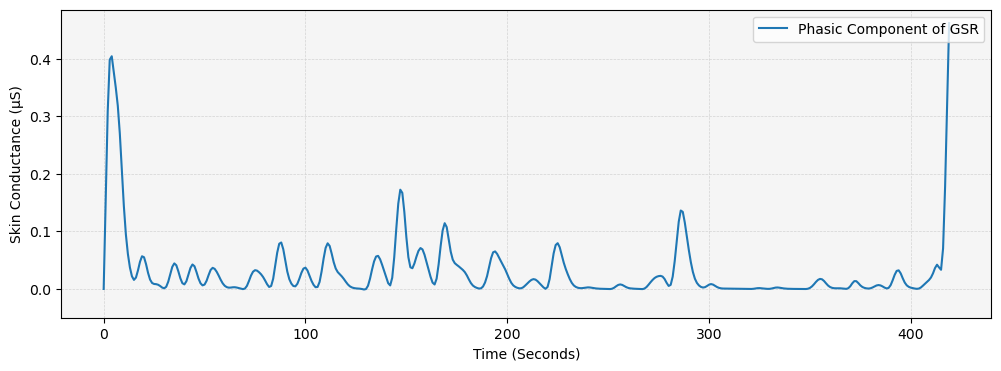

In [11]:
# Plotting The Phasic Component of The GSR Data

# Since the sampling rate is 1 Hz and 'filtered_gsr' is an array, a time series can be simply a range with the same length
time_series_filtered = np.arange(len(filtered_gsr))

# Now plot the filtered GSR data
plt.figure(figsize=(12, 4))
plt.plot(time_series_filtered, filtered_gsr, label='Phasic Component of GSR')
plt.xlabel('Time (Seconds)')
plt.ylabel('Skin Conductance (μS)')  # Adjusting the label

# Add grid, set face color, and other plot customizations
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.legend(loc='upper right')
plt.ylim(-0.05, max(filtered_gsr)*1.05)  # Set the y-axis limit to just above the max value

# Save the plot to the "Plots" directory
plots_dir = "./Plots"  # Make sure this directory exists
plt.savefig(os.path.join(plots_dir, 'Phasic_GSR_Data_Over_Time.png'))
plt.show()

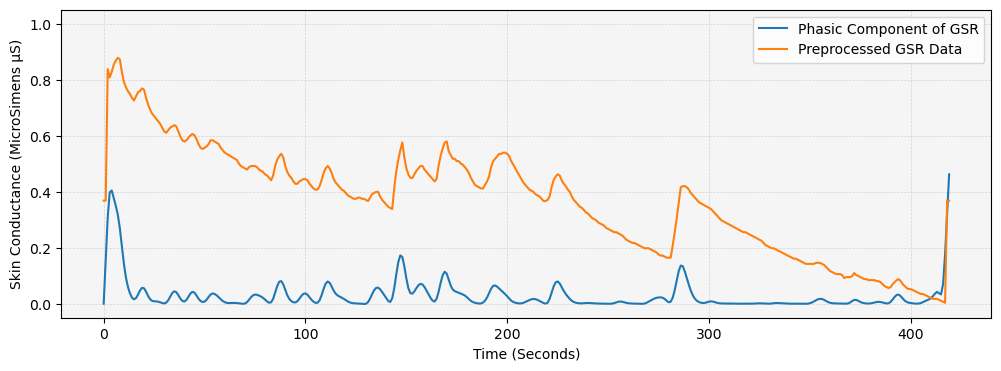

In [12]:
# Genarting Visually Comparison Plot of Two Sets of GSR Data ('Phasic Component of GSR' vs. 'Preprocessed GSR Data')

# Using seaborn's colour palette
palette = sns.color_palette("tab10")  

# Now plot both the phasic GSR data and the preprocessed GSR data
plt.figure(figsize=(12, 4))
plt.plot(time_series_filtered, filtered_gsr, label='Phasic Component of GSR', color=palette[0])
plt.plot(time_series_filtered, rol_mean_eda, label='Preprocessed GSR Data', color=palette[1])

plt.xlabel('Time (Seconds)')
plt.ylabel('Skin Conductance (MicroSimens μS)')

# Add grid, set face color, and other plot customizations
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')

# Add a legend to the plot
plt.legend(loc='upper right')

# Setting y-axis limits
plt.ylim(-0.05, 1.05)

plt.savefig(os.path.join(plots_dir, 'GSR_Data_Comparison_Over_Time.png'))

plt.show()

In [13]:
# Identifying Onset and Offsets

# Refrerring to the phasic component for the GSR data that was extracted using the cvxEDA algorithm "r"
# Two of the parameters defined in the previous step are needed to perform this step! (phasic_gsr and the sample_rate)

# Parameters for onset and offset detection
minDiff = 0.5  # Minimum acceptable time difference between onset and offset
onSetThreshold = 0.01  # Onset threshold

# Initialize variables for processing
onSet_offSet = []
tmpSet = []
onIsSet = False

# Loop through the phasic GSR data to find onsets and offsets
for i, data in enumerate(phasic_gsr):
    if onIsSet:
        if data < onSetThreshold:
            tmpSet.append(i)
            timeDifference = (tmpSet[1] - tmpSet[0]) / sample_rate
            if timeDifference > minDiff:
                onSet_offSet.append(tmpSet)
            tmpSet = []
            onIsSet = False
    elif data > onSetThreshold:
        tmpSet.append(i)
        onIsSet = True

onSet_offSet = np.array(onSet_offSet)

# 'onSet_offSet' now contains the onset and offset pairs
print(onSet_offSet)

[[  2  25]
 [ 32  40]
 [ 41  49]
 [ 51  59]
 [ 72  81]
 [ 84  94]
 [ 97 104]
 [108 121]
 [132 142]
 [143 164]
 [165 182]
 [189 203]
 [210 216]
 [221 233]
 [271 280]
 [282 295]
 [353 358]
 [372 374]
 [391 398]]


In [14]:
# Finding The Peaks-
#  a. Within each onset-offset window:
#     Locate the maximum amplitude value.
#  b. Calculate Peak Amplitude:
#     Subtract the amplitude value at onset from the maximum amplitude.
#  c. Threshold Check:
#     If the resulting peak amplitude is higher than the threshold, typically 0.005, count it as a peak.

# To start finding the peaks, some initializations 
peaklist = []
indexlist = []
checkForMax = False
peakIndex = 0
index = 0
Max = 0
ampThreshold  = 0.005

# Loop through the phasic GSR data to find peaks
for i, data in enumerate(phasic_gsr):
    if (index == len(onSet_offSet)):
        break
    if (checkForMax):
        startIndex = onSet_offSet[index][0]
        amplitude = data - phasic_gsr[startIndex]
        if (amplitude > Max):
            peakIndex = i
            Max = amplitude
        if (i == onSet_offSet[index][1]):
            # Check the threshold and add the peak to peaklist
            if (Max > ampThreshold):
                peaklist.append(Max)
                indexlist.append(peakIndex)
            Max = 0
            checkForMax = False
            index = index + 1
    elif (i == onSet_offSet[index][0]):
        checkForMax = True

# 'peaklist' contains the amplitudes of the peaks
# 'indexlist' contains the corresponding indices of the peaks in the phasic GSR data
print("Peaks:", peaklist)
print("Peak Indices:", indexlist)

Peaks: [0.03533327024702425, 0.03299491394866902, 0.024651611259467115, 0.019384837080285953, 0.07145510600518573, 0.020206458768269937, 0.051442267745806014, 0.043016005800720354, 0.1673173954322655, 0.10629032397614291, 0.0552545237288359, 0.0075206683556445705, 0.06929697296570735, 0.011021049056101443, 0.1271824251742193, 0.01913199481652114]
Peak Indices: [35, 44, 54, 75, 88, 100, 111, 136, 148, 169, 193, 213, 225, 277, 286, 394]


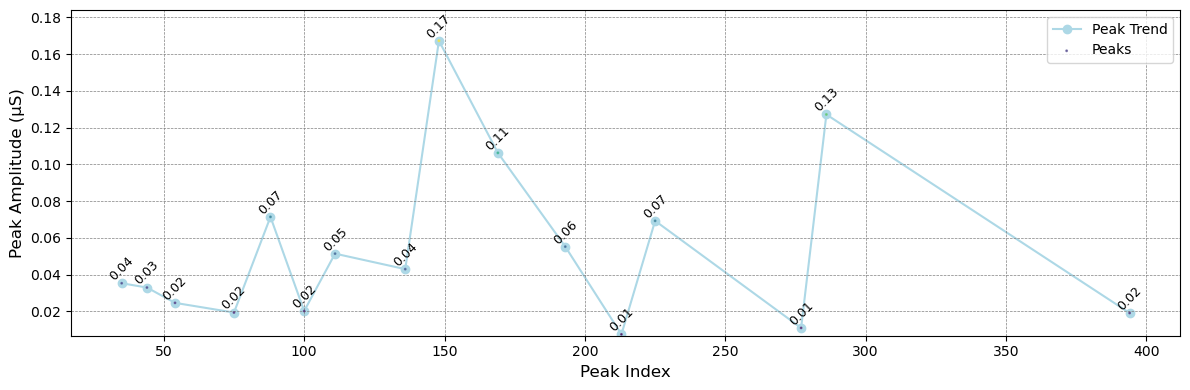

In [15]:
# Summerizing Peaks' & Their Amplitude 

# Creating a plot that summarizes the number of peaks nd their amplitudes 
plt.figure(figsize=(12, 4))

# Plotting the peaks with a line and scatter plot for better visualization
plt.plot(indexlist, peaklist, '-o', color='lightblue', label='Peak Trend', zorder=1)
scatter = plt.scatter(indexlist, peaklist, c=peaklist, cmap='viridis', s=(peaklist - min(peaklist) + 1)**2, label='Peaks', zorder=2, alpha=0.6)

# Annotate each peak with its amplitude
for x, y in zip(indexlist, peaklist):
    plt.text(x, y, f'{round(y, 2)}', color='black', fontsize=9, ha='center', va='bottom', rotation=45)

# Customizations
plt.xlabel('Peak Index', fontsize=12)
plt.ylabel('Peak Amplitude (μS)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
plt.legend()

# Set the y-axis limits to ensure all points are visible
y_upper_limit = max(peaklist) + (max(peaklist) * 0.1)  # 10% above the highest peak
plt.ylim(min(peaklist) - (min(peaklist) * 0.1), y_upper_limit)  # 10% below the lowest peak and above the highest peak

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'Profile_of_Galvanic_Skin_Response_Peaks.png'))
plt.show()


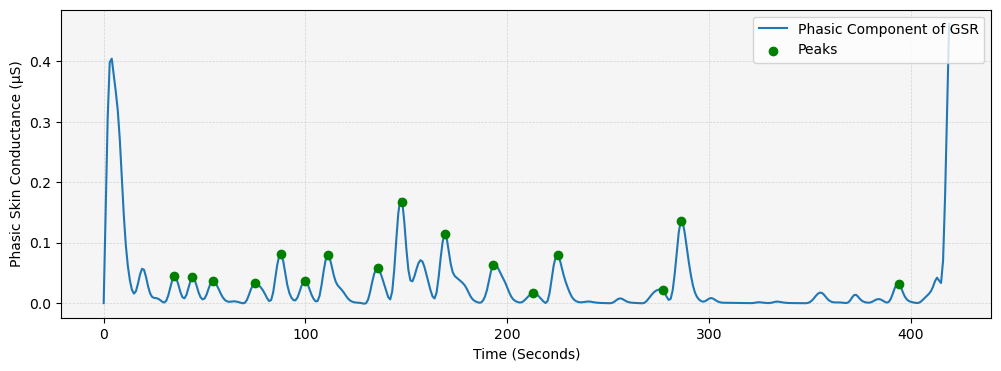

In [16]:
# Plotting The Peaks
# First, plot the phasic GSR data
plt.figure(figsize=(12, 4))
plt.plot(time_series_filtered, filtered_gsr, label='Phasic Component of GSR')

# Plot the peaks on top of the phasic GSR data
# 'indexlist' contains the indices of the peaks in the phasic GSR data
# 'peaklist' contains the amplitudes of the peaks 

peak_amplitudes = [filtered_gsr[index] for index in indexlist]
plt.scatter(np.array(indexlist), peak_amplitudes, color='green', label='Peaks', zorder=3)

plt.xlabel('Time (Seconds)')
plt.ylabel('Phasic Skin Conductance (μS)')

# Add grid, set face color, and other plot customizations
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')

# Add a legend to the plot
plt.legend(loc='upper right')

# Save the plot to the "Plots" directory
plt.savefig(os.path.join(plots_dir, 'Phasic_GSR_Data_with_Peaks.png'))
plt.show()


In [17]:
# Extracting Rise Time & Recovery Time 
# Rise time refers to the time it takes for the skin conductance response (SCR) to go from its onset to its peak.
# Recovery time, or decay time, is the time it takes for the SCR to decrease from its peak back to baseline.

def calculate_rise_recovery_times(phasic_gsr, onSet_offSet, indexlist, sample_rate):
    """
    Calculates the rise and recovery times for each identified peak in the phasic GSR data.

    Parameters:
    - phasic_gsr: The phasic GSR data array.
    - onSet_offSet: An array of onset and offset index pairs.
    - indexlist: A list of indices corresponding to the peaks in the phasic GSR data.
    - sample_rate: The sampling rate of the GSR data.

    Returns:
    - A list of tuples where each tuple contains (rise_time, recovery_time) for each peak.
    """
    times = []

    for peak_index in indexlist:
        # Find the corresponding onset-offset window for the current peak
        window = next(window for window in onSet_offSet if window[0] <= peak_index <= window[1])

        onset_index, offset_index = window
        peak_amplitude = phasic_gsr[peak_index]

        # Calculate rise time (onset to peak)
        rise_time = (peak_index - onset_index) / sample_rate

        # Calculate recovery time (peak to offset)
        recovery_time = (offset_index - peak_index) / sample_rate

        times.append((rise_time, recovery_time))

    return times

# Example usage
sample_rate = 1.0  # The sampling rate here
rise_recovery_times = calculate_rise_recovery_times(phasic_gsr, onSet_offSet, indexlist, sample_rate)

# Printing rise and recovery times
for i, (rise, recovery) in enumerate(rise_recovery_times, 1):
    print(f"Peak {i}: Rise Time = {rise}s, Recovery Time = {recovery}s")


Peak 1: Rise Time = 3.0s, Recovery Time = 5.0s
Peak 2: Rise Time = 3.0s, Recovery Time = 5.0s
Peak 3: Rise Time = 3.0s, Recovery Time = 5.0s
Peak 4: Rise Time = 3.0s, Recovery Time = 6.0s
Peak 5: Rise Time = 4.0s, Recovery Time = 6.0s
Peak 6: Rise Time = 3.0s, Recovery Time = 4.0s
Peak 7: Rise Time = 3.0s, Recovery Time = 10.0s
Peak 8: Rise Time = 4.0s, Recovery Time = 6.0s
Peak 9: Rise Time = 5.0s, Recovery Time = 16.0s
Peak 10: Rise Time = 4.0s, Recovery Time = 13.0s
Peak 11: Rise Time = 4.0s, Recovery Time = 10.0s
Peak 12: Rise Time = 3.0s, Recovery Time = 3.0s
Peak 13: Rise Time = 4.0s, Recovery Time = 8.0s
Peak 14: Rise Time = 6.0s, Recovery Time = 3.0s
Peak 15: Rise Time = 4.0s, Recovery Time = 9.0s
Peak 16: Rise Time = 3.0s, Recovery Time = 4.0s


<Figure size 1200x400 with 0 Axes>

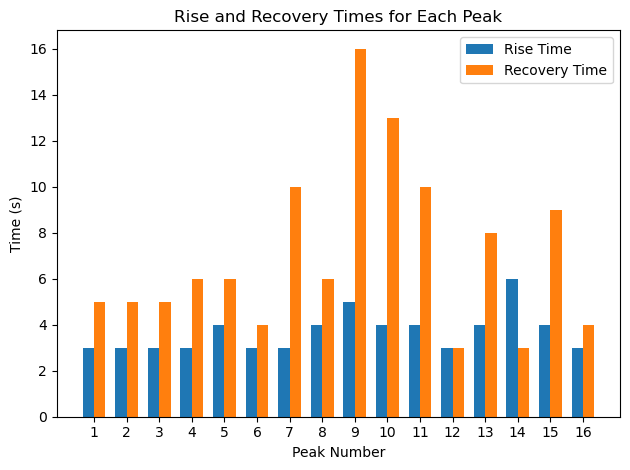

In [18]:
# Plotting Rise & Recovery Times 
rise_times = [rt[0] for rt in rise_recovery_times]
recovery_times = [rt[1] for rt in rise_recovery_times]
peak_indices = range(1, len(rise_times) + 1)

# Creating a plot
plt.figure(figsize=(12, 4))
fig, ax = plt.subplots()

# Setting the width of the bars
bar_width = 0.35

# Setting positions of the bars
index = range(len(peak_indices))

# Plotting both rise and recovery times
rise_bar = ax.bar(index, rise_times, bar_width, label='Rise Time')
recovery_bar = ax.bar([p + bar_width for p in index], recovery_times, bar_width, label='Recovery Time')

# Adding some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Peak Number')
ax.set_ylabel('Time (s)')
ax.set_title('Rise and Recovery Times for Each Peak')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(peak_indices)
ax.legend()

# Making the layout tight to fit everything
plt.tight_layout()


plt.savefig(os.path.join(plots_dir, 'Rise_Recovery_Times_Plot.png'))
plt.show()



## Workload Levels Analysis with GSR Features

In our investigation, we focus on three distinct **workload levels** derived from the study's design—specifically, `Level 0`, `Level 1`, and `Level 2`. 

The upcoming segment of our code will align the *Galvanic Skin Response (GSR)* statistical features—namely, the **number of peaks**, **mean peak amplitude**, and **maximum peak amplitude**—directly with these designated workload levels.

Our objective is to scrutinize the correlation between these **workload intensities** and the corresponding **statistical features of the GSR peaks**. This analysis may unveil any pronounced discrepancies that exist across different levels of workload intensity.

Stay tuned as we dive into the data and uncover the intricacies of physiological responses to varying work demands!
responses.


In [19]:
# Summarizing the level occurrences with their respective times

# Convert the 'datetime' column from strings to datetime objects
pt_1['datetime'] = pd.to_datetime(pt_1['datetime'])

# Calculate seconds from the start for each datetime entry
start_time = pt_1['datetime'].iloc[0]
pt_1['seconds_from_start'] = (pt_1['datetime'] - start_time).dt.total_seconds()

# Now, create a new DataFrame that summarizes the level occurrences with their respective seconds
level_times = pt_1[['level', 'seconds_from_start']].drop_duplicates()

# Optionally, you can sort the DataFrame based on seconds_from_start if it's not already sorted
level_times = level_times.sort_values(by='seconds_from_start')

# Now level_times DataFrame contains the unique seconds_from_start for each level
level_times

# Create a DataFrames folder if it does not exist
folder_directory = './DataFrames'

csv_file = os.path.join(folder_directory, 'level_times.csv')
# Save to CSV
level_times.to_csv(csv_file, index=False)

In [20]:
# Finding the start and end times for each level in the dataset 

# To find the start time for each level, group by 'level' and get the first occurrence
start_times = level_times.groupby('level')['seconds_from_start'].first().reset_index(name='start_time')

# To find the end time for each level, group by 'level' and get the last occurrence
end_times = level_times.groupby('level')['seconds_from_start'].last().reset_index(name='end_time')

# Merge the start_times and end_times DataFrames on 'level'
level_start_end_times = pd.merge(start_times, end_times, on='level')

# Now level_start_end_times DataFrame contains the start and end time for each level
print(level_start_end_times)

# For these starting and ending times, I have double-checked the .CSV file for this specific participant and the results that appear here totally make sense
# The participant started level (2) at time 45:35:7 and ended that specific level at time 48:01:0
# The next level, after that, was level (1), which started at 49:26:1, resulting in an almost 85-second difference between the two levels.
# Similarly, level (1) ended at time 51:43:2 and level (0) started at time 53:12:3, which means there is almost 88 seconds difference

   level  start_time  end_time
0      0     456.618   591.871
1      1     230.386   367.516
2      2       0.000   145.273


In [21]:
# Mapping Peaks To Specific Time
# Calculate the time in seconds for each peak
time_of_peaks = [index / sample_rate for index in indexlist]

# Now 'time_of_peaks' contains the time in seconds from the start for each peak
print("Time of Peaks (in seconds):", time_of_peaks)

Time of Peaks (in seconds): [35.0, 44.0, 54.0, 75.0, 88.0, 100.0, 111.0, 136.0, 148.0, 169.0, 193.0, 213.0, 225.0, 277.0, 286.0, 394.0]


In [22]:
# Levels VS. Number of Peaks
# Initialize a dictionary to store the number of peaks for each level
peaks_per_level = {level: 0 for level in level_start_end_times['level']}

# Iterate over each level
for _, level_row in level_start_end_times.iterrows():
    level = level_row['level']
    start_time = level_row['start_time']
    end_time = level_row['end_time']
    
    # Count the number of peaks that fall within the start and end time for this level
    peaks_in_level = [time for time in time_of_peaks if start_time <= time <= end_time]
    peaks_per_level[level] = len(peaks_in_level)

# Output the results
for level, count in peaks_per_level.items():
    print(f"Level {level} has {count} peaks")


Level 0 has 0 peaks
Level 1 has 2 peaks
Level 2 has 8 peaks


In [23]:
# levels VS. Peaks' Amplitude 
# Create a data frame for peaks with their times and amplitudes
peaks_df = pd.DataFrame({
    'time_of_peak': time_of_peaks,
    'peak_amplitude': peak_amplitudes
})

# Defining a function that will find specific level for each peak time 
def find_level_for_peak(peak_time):
    for _, row in level_start_end_times.iterrows():
        if row['start_time'] <= peak_time <= row['end_time']:
            return row['level']
    return None  # or you could return a specific value to indicate the peak is outside all levels

# Apply the function to determine the level for each peak
peaks_df['level'] = peaks_df['time_of_peak'].apply(find_level_for_peak)

# Filter out any peaks that did not occur within a level; if necessary
peaks_df = peaks_df.dropna(subset=['level'])

# Now, peaks_df contains each peak's time, amplitude, and the level it occurred in
print(peaks_df)

    time_of_peak  peak_amplitude  level
0           35.0        0.044431    2.0
1           44.0        0.042518    2.0
2           54.0        0.036692    2.0
3           75.0        0.032628    2.0
4           88.0        0.080771    2.0
5          100.0        0.037002    2.0
6          111.0        0.079302    2.0
7          136.0        0.057463    2.0
13         277.0        0.021468    1.0
14         286.0        0.136283    1.0


In [24]:
# levels VS. Average GSR Response

# Initialize a dictionary to store the mean phasic GSR for each level
mean_phasic_gsr_per_level = {}

# The data's sampling frequency in Hz (this should be defined according to your data acquisition rate)
sample_rate = 1.0  

# Iterate over each level's start and end times
for _, row in level_start_end_times.iterrows():
    level = row['level']
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Calculate the indices corresponding to the start and end times
    start_index = int(start_time * sample_rate)  # Convert time to index assuming the array starts at time 0
    end_index = int(end_time * sample_rate)
    
    # Validate indices and select the segment of the filtered GSR data that falls within the current level's time frame
    if start_index < len(filtered_gsr) and end_index < len(filtered_gsr):
        gsr_segment = filtered_gsr[start_index:end_index]
        
        # Calculate the mean phasic GSR for this segment if the segment is not empty
        if gsr_segment.size > 0:
            mean_phasic_gsr = np.mean(gsr_segment)
        else:
            mean_phasic_gsr = np.nan  # Assign NaN if the segment is empty
    else:
        mean_phasic_gsr = np.nan  # Assign NaN if indices are out of bounds

    # Store the result in the dictionary
    mean_phasic_gsr_per_level[level] = mean_phasic_gsr

# Convert the dictionary to a DataFrame for easy reading
mean_phasic_gsr_per_level_df = pd.DataFrame(list(mean_phasic_gsr_per_level.items()), columns=['level', 'mean_phasic_gsr'])

# Print the resulting DataFrame
print(mean_phasic_gsr_per_level_df)


   level  mean_phasic_gsr
0    0.0              NaN
1    1.0         0.010387
2    2.0         0.042562


In [25]:
# Utlizing Indicies Instead of Time 
# Count the number of data points for each level
cell_counts = level_times.groupby('level').size().reset_index(name='count')
level_start_end_counts = pd.merge(level_start_end_times, cell_counts, on='level')
# Now level_start_end_counts DataFrame contains the start and end time for each level, along with the count of data points for that level
print(level_start_end_counts)


   level  start_time  end_time  count
0      0     456.618   591.871    136
1      1     230.386   367.516    138
2      2       0.000   145.273    146


In [26]:
# Number of Peaks & Amplitude of The Peaks
# Initialization
level_details = {2: [], 1: [], 0: []}

# Mapping peaks to levels and collecting amplitudes
for peak_idx, amplitude in zip(indexlist, peaklist):
    if 0 <= peak_idx <= 145:
        level_details[2].append(amplitude)
    elif 146 <= peak_idx <= 285:
        level_details[1].append(amplitude)
    else:
        level_details[0].append(amplitude)

# Output the result
for level, amplitudes in level_details.items():
    print(f"Level {level}: {len(amplitudes)} peaks, Amplitudes: {amplitudes}")


Level 2: 8 peaks, Amplitudes: [0.03533327024702425, 0.03299491394866902, 0.024651611259467115, 0.019384837080285953, 0.07145510600518573, 0.020206458768269937, 0.051442267745806014, 0.043016005800720354]
Level 1: 6 peaks, Amplitudes: [0.1673173954322655, 0.10629032397614291, 0.0552545237288359, 0.0075206683556445705, 0.06929697296570735, 0.011021049056101443]
Level 0: 2 peaks, Amplitudes: [0.1271824251742193, 0.01913199481652114]


Level 2: 8 peaks, Amplitudes: [0.03533327024702425, 0.03299491394866902, 0.024651611259467115, 0.019384837080285953, 0.07145510600518573, 0.020206458768269937, 0.051442267745806014, 0.043016005800720354]
Level 1: 6 peaks, Amplitudes: [0.1673173954322655, 0.10629032397614291, 0.0552545237288359, 0.0075206683556445705, 0.06929697296570735, 0.011021049056101443]
Level 0: 2 peaks, Amplitudes: [0.1271824251742193, 0.01913199481652114]


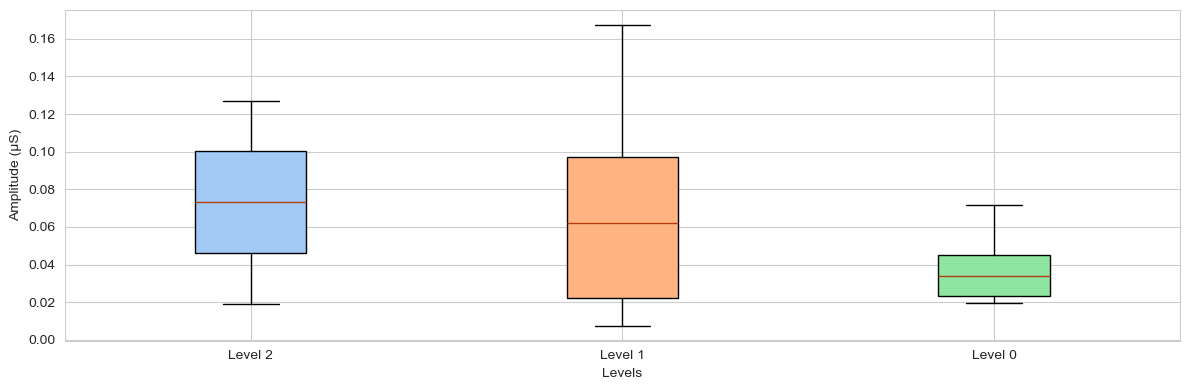

In [27]:
# Number of Peaks & Amplitude of The Peaks
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming 'indexlist' and 'peaklist' are defined elsewhere in your code

# Number of Peaks & Amplitude of The Peaks
# Initialization
level_details = {2: [], 1: [], 0: []}

# Mapping peaks to levels and collecting amplitudes
for peak_idx, amplitude in zip(indexlist, peaklist):
    if 0 <= peak_idx <= 145:
        level_details[2].append(amplitude)
    elif 146 <= peak_idx <= 285:
        level_details[1].append(amplitude)
    else:
        level_details[0].append(amplitude)

# Output the result
for level, amplitudes in level_details.items():
    print(f"Level {level}: {len(amplitudes)} peaks, Amplitudes: {amplitudes}")

# Visualizing the results
levels = ['Level 2', 'Level 1', 'Level 0']
amplitudes = [level_details[level] for level in sorted(level_details.keys())]

plt.figure(figsize=(12, 4))
sns.set_style("whitegrid") # Set the background to white grid for better clarity

# Use the "colorblind" palette provided by Seaborn
sns.set_palette(sns.color_palette("dark"))

# Creating the boxplot with colored boxes
bp = plt.boxplot(amplitudes, labels=levels, patch_artist=True)

# Set the colors for each box based on the "colorblind" palette
for patch, color in zip(bp['boxes'], sns.color_palette("pastel")):
    patch.set_facecolor(color)

plt.xlabel('Levels')
plt.ylabel('Amplitude (μS)')
plt.tight_layout() # Making the layout tight to fit everything
plt.savefig(os.path.join(plots_dir, 'Peak_Distribution_Plot.png'))
plt.show()


In [28]:
# Mean Phasic GSR Response 

# Calculate the mean for different levels
mean_level_2 = np.mean(phasic_gsr[:146])  # First 146 cells for level 2
mean_level_1 = np.mean(phasic_gsr[146:146+138])  # Next 138 cells for level 1
mean_level_0 = np.mean(phasic_gsr[146+138:])  # Last 136 cells for level 0

# Print out the results
print(f"Mean phasic GSR response for Level 2: {mean_level_2}")
print(f"Mean phasic GSR response for Level 1: {mean_level_1}")
print(f"Mean phasic GSR response for Level 0: {mean_level_0}")


Mean phasic GSR response for Level 2: 0.042645187031022276
Mean phasic GSR response for Level 1: 0.027686671551442957
Mean phasic GSR response for Level 0: 0.019328575407956034


In [29]:
# Number of Peaks & Amplitude of The Peaks & Mean Phasic Response Summary
# Initialization
level_details = {2: [], 1: [], 0: []}

# Mapping peaks to levels and collecting amplitudes
for peak_idx, amplitude in zip(indexlist, peaklist):
    if 0 <= peak_idx <= 145:
        level_details[2].append(round(amplitude, 3))
    elif 146 <= peak_idx <= 285:
        level_details[1].append(round(amplitude, 3))
    else:
        level_details[0].append(round(amplitude, 3))

# Mean phasic GSR response for each level
mean_phrasic_response = {
    2: round(0.042645187031022276, 3),
    1: round(0.027686671551442957, 3),
    0: round(0.019328575407956034, 3)
}

# Output the result in a table with mean phasic response as the last column
table = []
for level, amplitudes in level_details.items():
    # Reorder the columns here
    table.append([f"Level {level}", len(amplitudes), amplitudes, mean_phrasic_response[level]])

# Update headers with the mean phasic response as the last column
headers = ["Level", "Number of Peaks", "Amplitudes (μS)", "Mean Phasic Response (μS)"]
print(tabulate(table, headers=headers, tablefmt="fancy_grid"))


╒═════════╤═══════════════════╤═════════════════════════════════════════════════════════╤═════════════════════════════╕
│ Level   │   Number of Peaks │ Amplitudes (μS)                                         │   Mean Phasic Response (μS) │
╞═════════╪═══════════════════╪═════════════════════════════════════════════════════════╪═════════════════════════════╡
│ Level 2 │                 8 │ [0.035, 0.033, 0.025, 0.019, 0.071, 0.02, 0.051, 0.043] │                       0.043 │
├─────────┼───────────────────┼─────────────────────────────────────────────────────────┼─────────────────────────────┤
│ Level 1 │                 6 │ [0.167, 0.106, 0.055, 0.008, 0.069, 0.011]              │                       0.028 │
├─────────┼───────────────────┼─────────────────────────────────────────────────────────┼─────────────────────────────┤
│ Level 0 │                 2 │ [0.127, 0.019]                                          │                       0.019 │
╘═════════╧═══════════════════╧═════════

**Statistical Analysis 📊**

**Confirming Relationships Between GSR Features and Levels**

In this phase, we will be conducting **statistical analysis** to reveal the relationships between **Galvanic Skin Response (GSR) features** and the diverse **levels** they represent.


In [30]:
# Mean Phasic GSR Response VS. Levels
# Segmenting the data by levels
level_2_data = phasic_gsr[:146]
level_1_data = phasic_gsr[146:146+138]
level_0_data = phasic_gsr[146+138:]

# Performing ANOVA
f_value, p_value = stats.f_oneway(level_2_data, level_1_data, level_0_data)

# Calculate degrees of freedom
df_between = 2
df_within = len(phasic_gsr) - 3
df_total = len(phasic_gsr) - 1

# Calculate Sum of Squares (SS) and Mean Squares (MS)
mean_total = np.mean(phasic_gsr)
ss_total = np.sum((phasic_gsr - mean_total) ** 2)
ss_between = (len(level_2_data) * (np.mean(level_2_data) - mean_total) ** 2 +
              len(level_1_data) * (np.mean(level_1_data) - mean_total) ** 2 +
              len(level_0_data) * (np.mean(level_0_data) - mean_total) ** 2)
ss_within = np.sum((level_2_data - np.mean(level_2_data)) ** 2) + \
            np.sum((level_1_data - np.mean(level_1_data)) ** 2) + \
            np.sum((level_0_data - np.mean(level_0_data)) ** 2)
ms_between = ss_between / df_between
ms_within = ss_within / df_within

# Rounding for presentation
ss_between_rounded = round(ss_between, 3)
ss_within_rounded = round(ss_within, 3)
ss_total_rounded = round(ss_total, 3)
ms_between_rounded = round(ms_between, 3)
ms_within_rounded = round(ms_within, 3)
f_value_rounded = round(f_value, 3)
p_value_rounded = round(p_value, 3)

# Creating and printing the table
table = [["Source of Variation", "SS", "df", "MS", "F", "P-value"],
         ["Between Groups", ss_between_rounded, df_between, ms_between_rounded, f_value_rounded, p_value_rounded],
         ["Within Groups", ss_within_rounded, df_within, ms_within_rounded, "", ""],
         ["Total", ss_total_rounded, df_total, "", "", ""]]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Interpreting the Results
if p_value < 0.05:
    print("There is a significant difference in mean phasic GSR responses across levels.")
else:
    print("There is no significant difference in mean phasic GSR responses across levels.")

╒═══════════════════════╤═══════╤══════╤═══════╤═══════╤═══════════╕
│ Source of Variation   │    SS │   df │ MS    │ F     │ P-value   │
╞═══════════════════════╪═══════╪══════╪═══════╪═══════╪═══════════╡
│ Between Groups        │ 0.04  │    2 │ 0.02  │ 5.518 │ 0.004     │
├───────────────────────┼───────┼──────┼───────┼───────┼───────────┤
│ Within Groups         │ 1.495 │  417 │ 0.004 │       │           │
├───────────────────────┼───────┼──────┼───────┼───────┼───────────┤
│ Total                 │ 1.534 │  419 │       │       │           │
╘═══════════════════════╧═══════╧══════╧═══════╧═══════╧═══════════╛
There is a significant difference in mean phasic GSR responses across levels.


In [31]:
# "Rise & Recovery Times" VS. Levels
# Extracting rise and recovery times separately for each level
# Splitting the data into levels
level_2 = rise_recovery_times[:8]
level_1 = rise_recovery_times[8:14]
level_0 = rise_recovery_times[14:]

rise_times_level_2 = [time[0] for time in level_2]
rise_times_level_1 = [time[0] for time in level_1]
rise_times_level_0 = [time[0] for time in level_0]

recovery_times_level_2 = [time[1] for time in level_2]
recovery_times_level_1 = [time[1] for time in level_1]
recovery_times_level_0 = [time[1] for time in level_0]

# Then, use these lists for the Levene's test
print("Homogeneity of Variances (Rise Times):", stats.levene(rise_times_level_2, rise_times_level_1, rise_times_level_0, center='mean'))
print("Homogeneity of Variances (Recovery Times):", stats.levene(recovery_times_level_2, recovery_times_level_1, recovery_times_level_0, center='mean'))
# Kruskal-Wallis H-test for Rise Times
kruskal_result_rise = stats.kruskal(rise_times_level_2, rise_times_level_1, rise_times_level_0)
print("Kruskal-Wallis H-test (Rise Times):", kruskal_result_rise)

# Kruskal-Wallis H-test for Recovery Times
kruskal_result_recovery = stats.kruskal(recovery_times_level_2, recovery_times_level_1, recovery_times_level_0)
print("Kruskal-Wallis H-test (Recovery Times):", kruskal_result_recovery)


Homogeneity of Variances (Rise Times): LeveneResult(statistic=1.751670378619152, pvalue=0.21203846649013572)
Homogeneity of Variances (Recovery Times): LeveneResult(statistic=4.3495166959578215, pvalue=0.035790623738705)
Kruskal-Wallis H-test (Rise Times): KruskalResult(statistic=5.4099821746880545, pvalue=0.06687091984144099)
Kruskal-Wallis H-test (Recovery Times): KruskalResult(statistic=0.6726457399103161, pvalue=0.7143924127298649)


In [32]:
# Although ANOVA is not a valid assumption, it will be performed in this cell 
# Function to perform ANOVA calculations and print the table
def anova_table(data_by_levels, data_label):
    # Unpack the levels
    level_2_data, level_1_data, level_0_data = data_by_levels
    
    # Combine all levels for total calculations
    all_data = np.concatenate(data_by_levels)
    
    # Performing ANOVA
    f_value, p_value = f_oneway(level_2_data, level_1_data, level_0_data)
    
    # Calculate degrees of freedom
    df_between = 2
    df_within = len(all_data) - 3
    df_total = len(all_data) - 1
    
    # Calculate Sum of Squares (SS) and Mean Squares (MS)
    mean_total = np.mean(all_data)
    ss_total = np.sum((all_data - mean_total) ** 2)
    ss_between = sum(len(level) * (np.mean(level) - mean_total) ** 2 for level in data_by_levels)
    ss_within = sum(np.sum((level - np.mean(level)) ** 2) for level in data_by_levels)
    ms_between = ss_between / df_between
    ms_within = ss_within / df_within
    
    # Preparing table data
    table_data = [
        ["Source of Variation", "SS", "df", "MS", "F", "P-value"],
        ["Between Groups", round(ss_between, 3), df_between, round(ms_between, 3), round(f_value, 3), round(p_value, 3)],
        ["Within Groups", round(ss_within, 3), df_within, round(ms_within, 3), "", ""],
        ["Total", round(ss_total, 3), df_total, "", "", ""]
    ]
    
    # Printing the table
    print(f"ANOVA Table for {data_label}:")
    print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))
    print("\n")

# Prepare data
rise_times_levels = [rise_times_level_2, rise_times_level_1, rise_times_level_0]
recovery_times_levels = [recovery_times_level_2, recovery_times_level_1, recovery_times_level_0]

# Generating and printing the tables
anova_table(rise_times_levels, "Rise Times")
anova_table(recovery_times_levels, "Recovery Times")


ANOVA Table for Rise Times:
╒═══════════════════════╤════════╤══════╤═══════╤═══════╤═══════════╕
│ Source of Variation   │     SS │   df │ MS    │ F     │ P-value   │
╞═══════════════════════╪════════╪══════╪═══════╪═══════╪═══════════╡
│ Between Groups        │  4.104 │    2 │ 2.052 │ 3.638 │ 0.056     │
├───────────────────────┼────────┼──────┼───────┼───────┼───────────┤
│ Within Groups         │  7.333 │   13 │ 0.564 │       │           │
├───────────────────────┼────────┼──────┼───────┼───────┼───────────┤
│ Total                 │ 11.438 │   15 │       │       │           │
╘═══════════════════════╧════════╧══════╧═══════╧═══════╧═══════════╛


ANOVA Table for Recovery Times:
╒═══════════════════════╤═════════╤══════╤════════╤═══════╤═══════════╕
│ Source of Variation   │      SS │   df │ MS     │ F     │ P-value   │
╞═══════════════════════╪═════════╪══════╪════════╪═══════╪═══════════╡
│ Between Groups        │  30.729 │    2 │ 15.365 │ 1.147 │ 0.348     │
├───────────────────

In [33]:
# GSR Peaks' Amplitude VS.Levels  (Welch's ANOVA)

# The amplitude data
amplitudes_level_2 = [0.03533327024702425, 0.03299491394866902, 0.024651611259467115, 0.019384837080285953, 0.07145510600518573, 0.020206458768269937, 0.051442267745806014, 0.043016005800720354]
amplitudes_level_1 = [0.1673173954322655, 0.10629032397614291, 0.0552545237288359, 0.0075206683556445705, 0.06929697296570735, 0.011021049056101443]
amplitudes_level_0 = [0.1271824251742193, 0.01913199481652114]

# Creating a DataFrame for pingouin
data = {
    'Amplitude': amplitudes_level_2 + amplitudes_level_1 + amplitudes_level_0,
    'Level': ['Level 2'] * len(amplitudes_level_2) + ['Level 1'] * len(amplitudes_level_1) + ['Level 0'] * len(amplitudes_level_0)
}

df = pd.DataFrame(data)

# Performing Welch's ANOVA
welch_anova_results = pg.welch_anova(dv='Amplitude', between='Level', data=df)

print(welch_anova_results)
# Overall, based on these results, there is no significant evidence to suggest that the GSR amplitudes vary significantly across the different levels being tested.

  Source  ddof1     ddof2         F     p-unc      np2
0  Level      2  2.312953  0.765901  0.555602  0.14261


In [34]:
# GSR Peaks' Amplitude VS.Levels  (ANOVA)
# Combining all levels for total calculations
all_amplitudes = amplitudes_level_2 + amplitudes_level_1 + amplitudes_level_0

# Performing ANOVA using scipy.stats
f_stat, p_value = f_oneway(amplitudes_level_2, amplitudes_level_1, amplitudes_level_0)

# Calculate degrees of freedom
df_between = 2
df_within = len(all_amplitudes) - 3
df_total = len(all_amplitudes) - 1

# Calculate Sum of Squares (SS)
mean_total = np.mean(all_amplitudes)
ss_total = np.sum((np.array(all_amplitudes) - mean_total) ** 2)
ss_between = sum([len(level) * (np.mean(level) - mean_total)**2 for level in [amplitudes_level_2, amplitudes_level_1, amplitudes_level_0]])
ss_within = ss_total - ss_between

# Calculate Mean Squares (MS)
ms_between = ss_between / df_between
ms_within = ss_within / df_within

# Create a nicely formatted table using `tabulate`
table_data = [
    ["Between Groups", ss_between, df_between, ms_between, f_stat, p_value],
    ["Within Groups", ss_within, df_within, ms_within, None, None],
    ["Total", ss_total, df_total, None, None, None]
]

# Using tabulate to format the ANOVA table
anova_table = tabulate(table_data, headers=["Source", "SS", "df", "MS", "F", "P-value"], tablefmt="grid")

print(anova_table)

+----------------+------------+------+------------+---------+-----------+
| Source         |         SS |   df |         MS |       F |   P-value |
+================+============+======+============+=========+===========+
| Between Groups | 0.00439415 |    2 | 0.00219708 | 1.08115 |   0.36784 |
+----------------+------------+------+------------+---------+-----------+
| Within Groups  | 0.0264182  |   13 | 0.00203217 |         |           |
+----------------+------------+------+------------+---------+-----------+
| Total          | 0.0308123  |   15 |            |         |           |
+----------------+------------+------+------------+---------+-----------+


In [35]:
# GSR Number of Peaks VS.Levels
from scipy.stats import kruskal

# Number of peaks for each level
peaks_level_2 = 8
peaks_level_1 = 6
peaks_level_0 = 2

# Perform Kruskal-Wallis test
statistic, p_value = kruskal([peaks_level_2], [peaks_level_1], [peaks_level_0])

# Print test results
print("Kruskal-Wallis Test:")
print("H statistic:", statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("The number of peaks varies significantly with different levels.")
else:
    print("There is no significant difference in the number of peaks across different levels.")


Kruskal-Wallis Test:
H statistic: 2.0
p-value: 0.36787944117144245
There is no significant difference in the number of peaks across different levels.
